In [1]:
import os
import cv2
import json
import base64
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models
from torch.optim.lr_scheduler import StepLR

import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/My Drive/tmp/train_dataset.zip" .
!unzip -q train_dataset.zip -d ./train_dataset

In [4]:
# Проверка содержимого
print("Содержимое архива:")
print(os.listdir('train_dataset'))

Содержимое архива:
['cv_synt_dataset', 'cv_open_dataset', 'baseline']


In [5]:
base_path = os.path.join('train_dataset', 'cv_open_dataset')

# Пути к изображениям и меткам
train_images_path = os.path.join(base_path, 'open_img')
train_labels_path = os.path.join(base_path, 'open_msk')

print("Примеры изображений в train:")
print(os.listdir(train_images_path)[:5])
print("Примеры меток в train:")
print(os.listdir(train_labels_path)[:5])

Примеры изображений в train:
['F2_1_1_2.ts_f_1000.jpg', 'F2_1_1_1.ts_f_500.jpg', '1711330053_0.jpg', 'F1_1_5_1.ts_f_500.jpg', '1709344621_0.jpg']
Примеры меток в train:
['F5_1_2_2.ts_f_1000.png', 'F2_1_1_1.ts_f_1000.png', '1711430853_0.png', '1711256271_0.png', 'F2_2_3_2.ts_f_1000.png']


In [7]:
def visualize_sample(image_path, label_path):
    """
    Визуализация изображения и его метки.
    """
    # Загрузка изображения и метки
    image = cv2.imread(image_path)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Отображение
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Изображение")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Метка")
    plt.imshow(label, cmap='gray')
    plt.axis('off')

    plt.show()

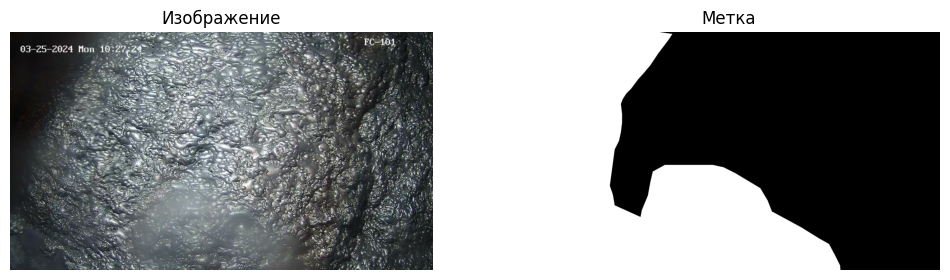

In [9]:
# Визуализация примеров
image_file = os.path.join(train_images_path, os.listdir(train_images_path)[2])
label_file = os.path.join(train_labels_path, os.listdir(train_labels_path)[2])
visualize_sample(image_file, label_file)

In [10]:
# Путь к меткам
label_dir = train_labels_path

# Список всех файлов меток
label_files = os.listdir(label_dir)

# Ищем уникальные значения в метках
unique_classes = set()
for label_file in label_files:
    label_path = os.path.join(label_dir, label_file)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    unique_classes.update(np.unique(label))

print(f"Количество классов: {len(unique_classes)}")
print(f"Уникальные классы: {unique_classes}")

Количество классов: 2
Уникальные классы: {0, 113}


# Импорт из raindrop

In [9]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'train_dataset/cv_synt_dataset'))

from raindrop.config import cfg
from raindrop.dropgenerator import generate_label, generateDrops

# Вспомогательные функции
def see_plot(pict, color='gray', size=(5, 5), title=''):
    """
    Функция визуализации изображения
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=size)
    plt.imshow(pict, cmap=color)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def synt_generation(real_img_fullpath, real_msk_fullpath, cfg, verbose=False):
    """
    Генерация синтетических изображений и масок.
    """
    img = cv2.imread(real_img_fullpath)[:, :, ::-1]
    msk = cv2.imread(real_msk_fullpath, cv2.IMREAD_GRAYSCALE)
    (h, w, c) = img.shape

    # Генерация капель
    List_of_Drops, label_map = generate_label(h, w, cfg)
    synt_img, _, synt_msk = generateDrops(real_img_fullpath, cfg, List_of_Drops)

    synt_img = np.array(synt_img)
    synt_msk = np.array(synt_msk)

    # Если синтетическая маска имеет три канала, преобразуем её в один
    if len(synt_msk.shape) == 3:
        synt_msk = cv2.cvtColor(synt_msk, cv2.COLOR_BGR2GRAY)

    # Маска должна быть бинарной
    synt_msk = (synt_msk > 0).astype(np.uint8) * 255

    # Объединяем реальную маску с синтетической
    combined_msk = (((msk > 0).astype(int) + (synt_msk > 0).astype(int)) > 0).astype(np.uint8) * 255

    if verbose:
        merged = synt_img.copy()
        merged[:, :, 0] = merged[:, :, 0] // 5 * 4 + combined_msk // 5
        for_plot = np.concatenate([synt_img, combined_msk, merged], axis=1)
        see_plot(for_plot, size=(20, 20), title='SYNT image-mask-merged')

    return synt_img, combined_msk

# Пути к данным

In [25]:
real_img_dir = "train_dataset/cv_open_dataset/open_img"  # Реальные изображения
real_msk_dir = "train_dataset/cv_open_dataset/open_msk"  # Реальные маски

extended_img_dir = "train_dataset/cv_synt_dataset/synt_img3"  # Для сохранения синтетических изображений
extended_msk_dir = "train_dataset/cv_synt_dataset/synt_msk3"  # Для сохранения синтетических масок

os.makedirs(extended_img_dir, exist_ok=True)
os.makedirs(extended_msk_dir, exist_ok=True)

# Проверяем существование папок с реальными данными
assert os.listdir(real_img_dir), "Папка с реальными изображениями пуста!"
assert os.listdir(real_msk_dir), "Папка с реальными масками пуста!"

# Получение списка общих файлов
real_imgs = sorted(os.listdir(real_img_dir))
real_msks = sorted(os.listdir(real_msk_dir))

img_names = [os.path.splitext(f)[0] for f in real_imgs]
msk_names = [os.path.splitext(f)[0] for f in real_msks]
common_names = list(set(img_names) & set(msk_names))

# Генерация синтетики на основе реальных

In [26]:
# Генерация синтетических данных
synt_data_count = 0

for name in tqdm(common_names, desc="Генерация синтетических данных"):
    img_path = os.path.join(real_img_dir, name + ".jpg")  # Реальное изображение
    msk_path = os.path.join(real_msk_dir, name + ".png")  # Реальная маска

    if not os.path.exists(img_path) or not os.path.exists(msk_path):
        print(f"Файл отсутствует: {img_path} или {msk_path}")
        continue

    for i in range(5):  # Создаем 5 синтетических вариантов для каждого изображения
        synt_img, synt_msk = synt_generation(img_path, msk_path, cfg, verbose=False)

        # Сохраняем синтетические данные
        cv2.imwrite(os.path.join(extended_img_dir, f"{name}_synt_{i}.png"), synt_img[:, :, ::-1])  # RGB->BGR
        cv2.imwrite(os.path.join(extended_msk_dir, f"{name}_synt_{i}.png"), synt_msk)  # 2D-маска
        synt_data_count += 1

# Копируем оригинальные данные в расширенный датасет
for name in tqdm(common_names, desc="Copying original data"):
    img_path = os.path.join(real_img_dir, name + ".jpg")
    msk_path = os.path.join(real_msk_dir, name + ".png")

    if not os.path.exists(img_path) or not os.path.exists(msk_path):
        print(f"Файл отсутствует: {img_path} или {msk_path}")
        continue

    # Сохраняем оригинальные данные
    img = cv2.imread(img_path)
    msk = cv2.imread(msk_path)
    cv2.imwrite(os.path.join(extended_img_dir, f"{name}_orig.jpg"), img)
    cv2.imwrite(os.path.join(extended_msk_dir, f"{name}_orig.png"), msk)

print(f"Генерация синтетических данных завершена. Создано {synt_data_count} синтетических изображений.")

Generating synthetic data:   9%|▉         | 22/250 [00:56<09:24,  2.47s/it]

Файл отсутствует: train_dataset/cv_open_dataset/open_img/29_1.jpg или train_dataset/cv_open_dataset/open_msk/29_1.png


Generating synthetic data:  27%|██▋       | 68/250 [02:57<07:06,  2.34s/it]

Файл отсутствует: train_dataset/cv_open_dataset/open_img/17_2.jpg или train_dataset/cv_open_dataset/open_msk/17_2.png


Generating synthetic data:  64%|██████▍   | 160/250 [07:12<04:08,  2.76s/it]

Файл отсутствует: train_dataset/cv_open_dataset/open_img/17_1.jpg или train_dataset/cv_open_dataset/open_msk/17_1.png


Generating synthetic data:  79%|███████▉  | 197/250 [08:49<02:02,  2.32s/it]

Файл отсутствует: train_dataset/cv_open_dataset/open_img/29_2.jpg или train_dataset/cv_open_dataset/open_msk/29_2.png


Copying original data:  11%|█         | 28/250 [00:01<00:07, 28.31it/s]

Файл отсутствует: train_dataset/cv_open_dataset/open_img/29_1.jpg или train_dataset/cv_open_dataset/open_msk/29_1.png


Copying original data:  28%|██▊       | 71/250 [00:03<00:07, 22.55it/s]

Файл отсутствует: train_dataset/cv_open_dataset/open_img/17_2.jpg или train_dataset/cv_open_dataset/open_msk/17_2.png


Copying original data:  66%|██████▌   | 165/250 [00:07<00:03, 26.24it/s]

Файл отсутствует: train_dataset/cv_open_dataset/open_img/17_1.jpg или train_dataset/cv_open_dataset/open_msk/17_1.png


Copying original data:  80%|███████▉  | 199/250 [00:09<00:02, 24.57it/s]

Файл отсутствует: train_dataset/cv_open_dataset/open_img/29_2.jpg или train_dataset/cv_open_dataset/open_msk/29_2.png


Copying original data: 100%|██████████| 250/250 [00:11<00:00, 22.27it/s]

Генерация синтетических данных завершена. Создано 1230 синтетических изображений.


# Подготовка к обучению

In [27]:
# Подготовка списка всех изображений и масок
all_img_files = sorted(os.listdir(extended_img_dir))
all_msk_files = sorted(os.listdir(extended_msk_dir))

# Сопоставление имён изображений и масок
img_dict = {os.path.splitext(f)[0]: f for f in all_img_files}
msk_dict = {os.path.splitext(f)[0]: f for f in all_msk_files}

# Выбираем только общие имена между изображениями и масками
common_all = sorted(set(img_dict.keys()) & set(msk_dict.keys()))
train_files, val_files = train_test_split(common_all, test_size=0.2, random_state=42)

print(f"Количество обучающих данных: {len(train_files)}")
print(f"Количество валидационных данных: {len(val_files)}")

Количество обучающих данных: 1180
Количество валидационных данных: 296


# Аугментации

In [28]:
# Аугментации
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.8),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45, p=0.7),
    A.GaussianBlur(p=0.3),
    A.CoarseDropout(max_holes=8, max_height=30, max_width=30, p=0.3),  # Симулирует "грязь"
    A.RandomFog(p=0.3),
    A.RandomSunFlare(flare_roi=(0, 0, 1, 1), p=0.3),
], additional_targets={'mask': 'mask'})


val_transform = A.Compose([], additional_targets={'mask': 'mask'})

# Генератор данных

In [29]:
class SegDataset(Dataset):
    def __init__(self, file_list, img_dir, msk_dir, transform=None, target_size=(288,480)):
        self.file_list = file_list
        self.img_dir = img_dir
        self.msk_dir = msk_dir
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        name = self.file_list[idx]
        if "_orig" in name:
            img_path = os.path.join(self.img_dir, name + ".jpg")
        else:
            img_path = os.path.join(self.img_dir, name + ".png")

        msk_path = os.path.join(self.msk_dir, name + ".png")

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Не найдено изображение: {img_path}")
        if not os.path.exists(msk_path):
            raise FileNotFoundError(f"Не найдена маска: {msk_path}")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (self.target_size[1], self.target_size[0]))
        msk = cv2.resize(msk, (self.target_size[1], self.target_size[0]))
        msk = (msk > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=msk)
            img, msk = augmented['image'], augmented['mask']

        img = torch.from_numpy(img.transpose(2,0,1)).float() / 255.0
        msk = torch.from_numpy(msk[None,...]).float()

        return img, msk

In [30]:
# Создаем датасеты и даталоадеры
train_dataset = SegDataset(train_files, extended_img_dir, extended_msk_dir, transform=train_transform)
val_dataset = SegDataset(val_files, extended_img_dir, extended_msk_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"Train steps: {len(train_loader)}, Val steps: {len(val_loader)}")

Train steps: 295, Val steps: 74


# U-net2

In [31]:
def mean_iou_torch(y_true, y_pred, threshold=0.5):
    """
    Вычисление средней IoU (Intersection over Union) для батча.

    :param y_true: Истинные маски (тензор PyTorch).
    :param y_pred: Предсказанные маски (тензор PyTorch, сырые логиты).
    :param threshold: Порог для бинаризации предсказаний.
    :return: Среднее IoU для текущего батча.
    """
    # Применяем сигмоиду и бинаризацию предсказаний
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()

    # Вычисляем пересечение и объединение
    intersection = (y_true * y_pred).sum(dim=(1, 2, 3))
    union = y_true.sum(dim=(1, 2, 3)) + y_pred.sum(dim=(1, 2, 3)) - intersection

    # IoU для каждого примера в батче
    iou = (intersection + 1e-7) / (union + 1e-7)

    # Средний IoU по батчу
    return iou.mean()

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

Используем устройство: cuda


In [33]:
class AttentionGate(nn.Module):
    def __init__(self, x_channels, g_channels, inter_channels):
        super(AttentionGate, self).__init__()
        self.theta_x = nn.Conv2d(x_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        self.phi_g = nn.Conv2d(g_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
        self.out_conv = nn.Conv2d(x_channels, g_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, g):
        if x.size(2) != g.size(2) or x.size(3) != g.size(3):
            g = F.interpolate(g, size=x.size()[2:], mode="bilinear", align_corners=False)

        theta_x = self.theta_x(x)
        phi_g = self.phi_g(g)
        combined = F.relu(theta_x + phi_g, inplace=True)
        psi = self.sigmoid(self.psi(combined))
        return self.out_conv(x * psi)


class LiteUNetWithAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(LiteUNetWithAttention, self).__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Извлекаем уровни из ResNet18
        self.enc1 = nn.Sequential(base_model.conv1, base_model.bn1, base_model.relu)
        self.enc2 = nn.Sequential(base_model.maxpool, base_model.layer1)
        self.enc3 = base_model.layer2                                                # 128 каналов
        self.enc4 = base_model.layer3                                                # 256 каналов
        self.enc5 = base_model.layer4                                                # 512 каналов

        # Bottleneck
        self.bottleneck = self._conv_block(512, 256)

        # Attention Gates
        self.att4 = AttentionGate(256, 128, 128)
        self.att3 = AttentionGate(128, 64, 64)
        self.att2 = AttentionGate(64, 64, 32)
        self.att1 = AttentionGate(64, 64, 32)

        # Декодеры
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=1)  # Приведение к 128 каналам
        self.decoder4 = self._conv_block(128, 128)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=1)   # Приведение к 64 каналам
        self.decoder3 = self._conv_block(64, 64)

        self.upconv2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=1)   # Приведение к 64 каналам
        self.decoder2 = self._conv_block(64, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(128, 64, kernel_size=1)   # Приведение к 64 каналам
        self.decoder1 = self._conv_block(64, 64)

        # Выходной слой
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Энкодеры
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        # Bottleneck
        bottleneck = self.bottleneck(enc5)

        # Декодеры с Attention Gate
        up4 = self.upconv4(bottleneck)
        att4 = self.att4(enc4, up4)
        merge4 = torch.cat([up4, att4], dim=1)
        merge4 = self.conv4(merge4)
        dec4 = self.decoder4(merge4)

        up3 = self.upconv3(dec4)
        att3 = self.att3(enc3, up3)
        merge3 = torch.cat([up3, att3], dim=1)
        merge3 = self.conv3(merge3)
        dec3 = self.decoder3(merge3)

        up2 = self.upconv2(dec3)
        att2 = self.att2(enc2, up2)
        merge2 = torch.cat([up2, att2], dim=1)
        merge2 = self.conv2(merge2)
        dec2 = self.decoder2(merge2)

        up1 = self.upconv1(dec2)
        att1 = self.att1(enc1, up1)
        merge1 = torch.cat([up1, att1], dim=1)
        merge1 = self.conv1(merge1)
        dec1 = self.decoder1(merge1)

        # Интерполяция до исходного размера
        dec1 = F.interpolate(dec1, size=x.shape[2:], mode='bilinear', align_corners=False)

        return self.final_conv(dec1)

In [ ]:
model = LiteUNetWithAttention(in_channels=3, out_channels=1).to(device)
x = torch.randn(1, 3, 288, 480).to(device)
y = model(x)
print(f"Output shape: {y.shape}")  # Ожидаемая форма: [1, 1, 288, 480]

Output shape: torch.Size([1, 1, 288, 480])


In [34]:
# Инициализируем модель
model = LiteUNetWithAttention(in_channels=3, out_channels=1).to(device)

# Функция потерь и оптимизатор
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

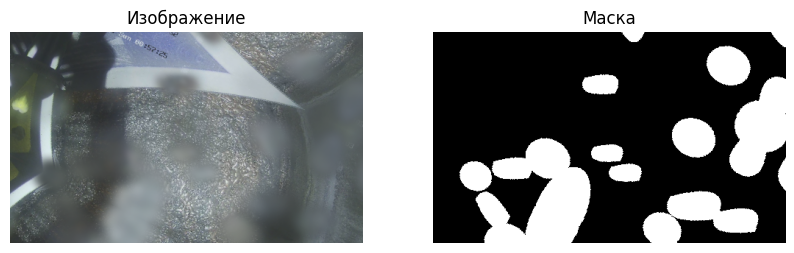

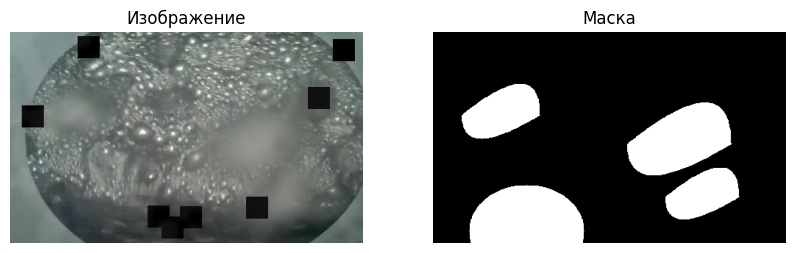

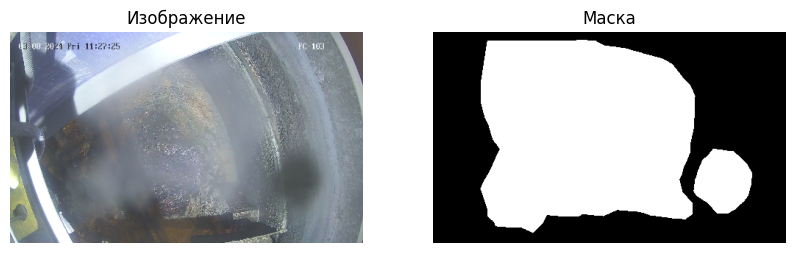

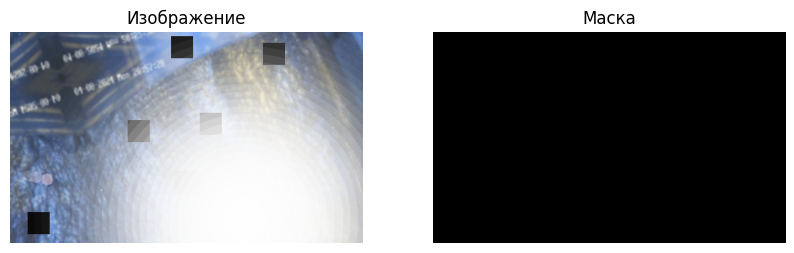

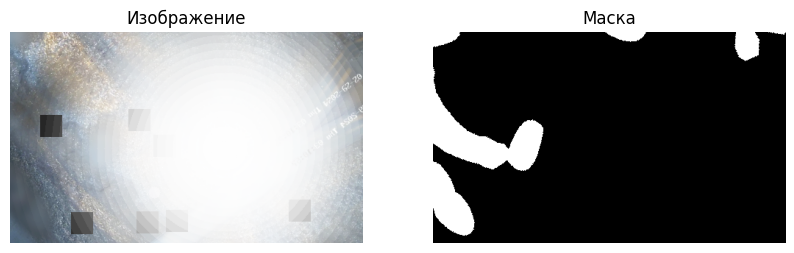

In [ ]:
# Визуализируем данные
for idx in range(5):
    img, msk = train_dataset[idx]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Изображение")
    plt.imshow(img.permute(1, 2, 0))  # Преобразование тензора в HWC
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Маска")
    plt.imshow(msk.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

In [35]:
best_val_iou = 0.0
num_epochs = 50

train_loss_history = []
train_iou_history = []
val_loss_history = []
val_iou_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_iou = 0, 0
    for imgs, msks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs, msks = imgs.to(device), msks.to(device)

        optimizer.zero_grad()
        output = model(imgs)  # Для U-Net
        loss = criterion(output, msks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += mean_iou_torch(msks, output).item()

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for imgs, msks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            imgs, msks = imgs.to(device), msks.to(device)
            output = model(imgs)
            loss = criterion(output, msks)
            val_loss += loss.item()
            val_iou += mean_iou_torch(msks, output).item()

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    scheduler.step(val_loss)  # Используем планировщик

    # Логируем метрики
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train mIoU={train_iou:.4f}, "
          f"Val Loss={val_loss:.4f}, Val mIoU={val_iou:.4f}")

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), "unet4_best.pth")
        print("Модель улучшена и сохранена.")

Epoch 1/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.87it/s]


Epoch 1/50: Train Loss=0.5159, Train mIoU=0.4007, Val Loss=0.4013, Val mIoU=0.5671
Модель улучшена и сохранена.


Epoch 2/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.90it/s]


Epoch 2/50: Train Loss=0.4356, Train mIoU=0.4526, Val Loss=0.3631, Val mIoU=0.6136
Модель улучшена и сохранена.


Epoch 3/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.95it/s]


Epoch 3/50: Train Loss=0.4108, Train mIoU=0.4826, Val Loss=0.2882, Val mIoU=0.6858
Модель улучшена и сохранена.


Epoch 4/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.94it/s]


Epoch 4/50: Train Loss=0.3937, Train mIoU=0.5138, Val Loss=0.3015, Val mIoU=0.6746


Epoch 5/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.93it/s]


Epoch 5/50: Train Loss=0.3792, Train mIoU=0.5260, Val Loss=0.2779, Val mIoU=0.6980
Модель улучшена и сохранена.


Epoch 6/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.93it/s]


Epoch 6/50: Train Loss=0.3622, Train mIoU=0.5405, Val Loss=0.2399, Val mIoU=0.7372
Модель улучшена и сохранена.


Epoch 7/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.94it/s]


Epoch 7/50: Train Loss=0.3586, Train mIoU=0.5498, Val Loss=0.2832, Val mIoU=0.7026


Epoch 8/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.94it/s]


Epoch 8/50: Train Loss=0.3347, Train mIoU=0.5783, Val Loss=0.2696, Val mIoU=0.7080


Epoch 9/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.94it/s]


Epoch 9/50: Train Loss=0.3397, Train mIoU=0.5693, Val Loss=0.2776, Val mIoU=0.7075


Epoch 10/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.88it/s]


Epoch 10/50: Train Loss=0.3281, Train mIoU=0.5904, Val Loss=0.2361, Val mIoU=0.7436
Модель улучшена и сохранена.


Epoch 11/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.94it/s]


Epoch 11/50: Train Loss=0.3157, Train mIoU=0.5998, Val Loss=0.2288, Val mIoU=0.7527
Модель улучшена и сохранена.


Epoch 12/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.93it/s]


Epoch 12/50: Train Loss=0.3152, Train mIoU=0.5937, Val Loss=0.2714, Val mIoU=0.7128


Epoch 13/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.91it/s]


Epoch 13/50: Train Loss=0.3063, Train mIoU=0.5954, Val Loss=0.2184, Val mIoU=0.7481


Epoch 14/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.92it/s]


Epoch 14/50: Train Loss=0.2884, Train mIoU=0.6279, Val Loss=0.2154, Val mIoU=0.7507


Epoch 15/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.93it/s]


Epoch 15/50: Train Loss=0.2890, Train mIoU=0.6361, Val Loss=0.2202, Val mIoU=0.7456


Epoch 16/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  4.95it/s]


Epoch 16/50: Train Loss=0.2957, Train mIoU=0.6163, Val Loss=0.2198, Val mIoU=0.7679
Модель улучшена и сохранена.


Epoch 17/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.92it/s]


Epoch 17/50: Train Loss=0.2955, Train mIoU=0.6150, Val Loss=0.2623, Val mIoU=0.7344


Epoch 18/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.92it/s]


Epoch 18/50: Train Loss=0.3064, Train mIoU=0.6182, Val Loss=0.2329, Val mIoU=0.7429


Epoch 19/50 [Val]: 100%|██████████| 74/74 [00:15<00:00,  4.88it/s]


Epoch 19/50: Train Loss=0.2973, Train mIoU=0.6088, Val Loss=0.2419, Val mIoU=0.7460


Epoch 20/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.04it/s]


Epoch 20/50: Train Loss=0.2820, Train mIoU=0.6335, Val Loss=0.2024, Val mIoU=0.7593


Epoch 21/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.06it/s]


Epoch 21/50: Train Loss=0.2788, Train mIoU=0.6341, Val Loss=0.2042, Val mIoU=0.7547


Epoch 22/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 22/50: Train Loss=0.2734, Train mIoU=0.6303, Val Loss=0.2117, Val mIoU=0.7544


Epoch 23/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.17it/s]


Epoch 23/50: Train Loss=0.2754, Train mIoU=0.6386, Val Loss=0.2218, Val mIoU=0.7578


Epoch 24/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.12it/s]


Epoch 24/50: Train Loss=0.2791, Train mIoU=0.6309, Val Loss=0.2177, Val mIoU=0.7705
Модель улучшена и сохранена.


Epoch 25/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 25/50: Train Loss=0.2682, Train mIoU=0.6434, Val Loss=0.2211, Val mIoU=0.7599


Epoch 26/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 26/50: Train Loss=0.2835, Train mIoU=0.6258, Val Loss=0.2071, Val mIoU=0.7733
Модель улучшена и сохранена.


Epoch 27/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.14it/s]


Epoch 27/50: Train Loss=0.2743, Train mIoU=0.6462, Val Loss=0.2100, Val mIoU=0.7448


Epoch 28/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 28/50: Train Loss=0.2639, Train mIoU=0.6493, Val Loss=0.2105, Val mIoU=0.7532


Epoch 29/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 29/50: Train Loss=0.2749, Train mIoU=0.6422, Val Loss=0.1985, Val mIoU=0.7742
Модель улучшена и сохранена.


Epoch 30/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 30/50: Train Loss=0.2619, Train mIoU=0.6424, Val Loss=0.2012, Val mIoU=0.7767
Модель улучшена и сохранена.


Epoch 31/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch 31/50: Train Loss=0.2709, Train mIoU=0.6432, Val Loss=0.2055, Val mIoU=0.7717


Epoch 32/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch 32/50: Train Loss=0.2640, Train mIoU=0.6446, Val Loss=0.2325, Val mIoU=0.7558


Epoch 33/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.16it/s]


Epoch 33/50: Train Loss=0.2645, Train mIoU=0.6540, Val Loss=0.2085, Val mIoU=0.7730


Epoch 34/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.16it/s]


Epoch 34/50: Train Loss=0.2626, Train mIoU=0.6550, Val Loss=0.1968, Val mIoU=0.7776
Модель улучшена и сохранена.


Epoch 35/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch 35/50: Train Loss=0.2555, Train mIoU=0.6653, Val Loss=0.2084, Val mIoU=0.7708


Epoch 36/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.16it/s]


Epoch 36/50: Train Loss=0.2676, Train mIoU=0.6486, Val Loss=0.1990, Val mIoU=0.7774


Epoch 37/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 37/50: Train Loss=0.2651, Train mIoU=0.6583, Val Loss=0.1911, Val mIoU=0.7773


Epoch 38/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch 38/50: Train Loss=0.2562, Train mIoU=0.6593, Val Loss=0.1993, Val mIoU=0.7830
Модель улучшена и сохранена.


Epoch 39/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.16it/s]


Epoch 39/50: Train Loss=0.2621, Train mIoU=0.6588, Val Loss=0.2176, Val mIoU=0.7640


Epoch 40/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch 40/50: Train Loss=0.2494, Train mIoU=0.6637, Val Loss=0.2022, Val mIoU=0.7804


Epoch 41/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.16it/s]


Epoch 41/50: Train Loss=0.2481, Train mIoU=0.6704, Val Loss=0.2008, Val mIoU=0.7865
Модель улучшена и сохранена.


Epoch 42/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 42/50: Train Loss=0.2523, Train mIoU=0.6711, Val Loss=0.1967, Val mIoU=0.7814


Epoch 43/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.17it/s]


Epoch 43/50: Train Loss=0.2520, Train mIoU=0.6610, Val Loss=0.1885, Val mIoU=0.7859


Epoch 44/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch 44/50: Train Loss=0.2515, Train mIoU=0.6524, Val Loss=0.2009, Val mIoU=0.7842


Epoch 45/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.16it/s]


Epoch 45/50: Train Loss=0.2570, Train mIoU=0.6632, Val Loss=0.1898, Val mIoU=0.7720


Epoch 46/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.17it/s]


Epoch 46/50: Train Loss=0.2391, Train mIoU=0.6690, Val Loss=0.1942, Val mIoU=0.7727


Epoch 47/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch 47/50: Train Loss=0.2475, Train mIoU=0.6755, Val Loss=0.2062, Val mIoU=0.7783


Epoch 48/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch 48/50: Train Loss=0.2544, Train mIoU=0.6655, Val Loss=0.1986, Val mIoU=0.7792


Epoch 49/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.17it/s]


Epoch 49/50: Train Loss=0.2440, Train mIoU=0.6763, Val Loss=0.2241, Val mIoU=0.7564


Epoch 50/50 [Val]: 100%|██████████| 74/74 [00:14<00:00,  5.16it/s]


Epoch 50/50: Train Loss=0.2544, Train mIoU=0.6618, Val Loss=0.1862, Val mIoU=0.7909
Модель улучшена и сохранена.


In [36]:
# Загружаем сохранённые веса лучшей модели
model = LiteUNetWithAttention(in_channels=3, out_channels=1).to(device)

try:
    model.load_state_dict(torch.load("unet4_best.pth", map_location=device))
    print("Модель успешно загружена.")
except FileNotFoundError:
    print("Файл с весами модели не найден. Убедитесь, что файл 'unet4_best.pth' находится в текущей директории.")
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")

model.eval()

print(f"Лучший показатель Val mIoU: {best_val_iou:.4f}")

Модель успешно загружена.
Лучший показатель Val mIoU: 0.7909


<ipython-input-36-88a94c780db7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet4_best.pth", map_location=device))


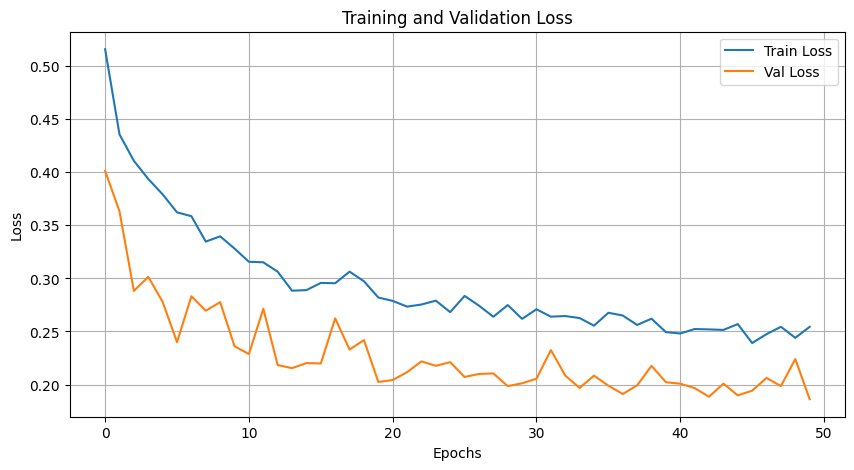

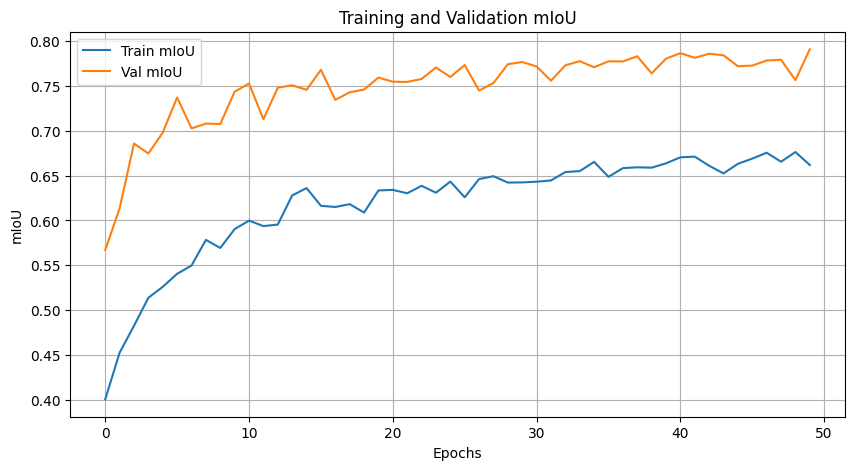

In [37]:
# Визуализация метрик обучения:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation mIoU")
plt.plot(train_iou_history, label="Train mIoU")
plt.plot(val_iou_history, label="Val mIoU")
plt.xlabel("Epochs")
plt.ylabel("mIoU")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
def visualize_results(model, test_loader, device='cpu'):
    """
    Визуализация предсказаний модели на тестовом наборе.

    :param model: Обученная модель (PyTorch).
    :param test_loader: DataLoader тестовых данных.
    :param device: Устройство ('cpu' или 'cuda').
    """
    model.eval()
    imgs, msks = next(iter(test_loader))  # Получаем первый батч
    imgs, msks = imgs.to(device), msks.to(device)

    with torch.no_grad():
        output = model(imgs)  # Для U-Net предсказания возвращаются напрямую
        pred_masks = torch.sigmoid(output) > 0.5  # Бинаризация
        pred_masks = pred_masks.cpu().numpy().astype(np.uint8)  # Перевод в NumPy

    # Переводим изображения обратно в NumPy для визуализации
    # imgs.shape: (B, C, H, W)
    # Перекладка каналов: (C, H, W) -> (H, W, C) и умножение на 255
    img_np = imgs.cpu().numpy().transpose(0, 2, 3, 1)
    img_np = (img_np * 255).astype(np.uint8)

    # msks.shape: (B, 1, H, W) -> squeeze до (B, H, W)
    msks_np = msks.cpu().numpy().squeeze()

    # Визуализируем первый пример из батча
    idx = 0
    plt.figure(figsize=(12, 6))

    # Оригинальное изображение
    plt.subplot(1, 3, 1)
    plt.title("Оригинальное изображение")
    plt.imshow(img_np[idx])  # RGB изображение
    plt.axis('off')

    # Истинная маска
    plt.subplot(1, 3, 2)
    plt.title("Истинная маска")
    plt.imshow(msks_np[idx], cmap='gray')
    plt.axis('off')

    # Предсказанная маска
    plt.subplot(1, 3, 3)
    plt.title("Предсказанная маска")
    plt.imshow(pred_masks[idx].squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

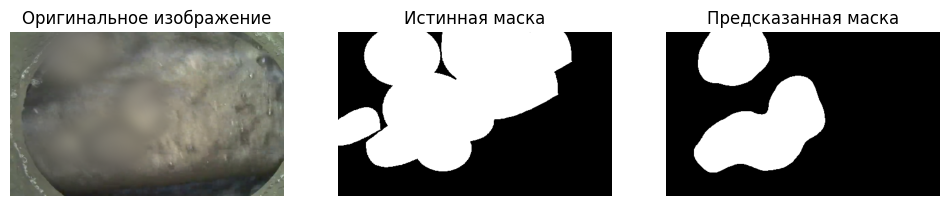

In [39]:
# Визуализация предсказаний
visualize_results(model, val_loader, device=device)

In [40]:
# Загрузка сохранённых весов
saved_weights = torch.load("unet4_best.pth", map_location=device)

# Сравнение ключей
model = LiteUNetWithAttention(in_channels=3, out_channels=1).to(device)
current_keys = set(model.state_dict().keys())
saved_keys = set(saved_weights.keys())

# Найти отсутствующие и дополнительные ключи
missing_keys = current_keys - saved_keys
unexpected_keys = saved_keys - current_keys

print("Отсутствующие ключи:", missing_keys)
print("Неожиданные ключи:", unexpected_keys)

<ipython-input-40-7843d1c0d936>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_weights = torch.load("unet4_best.pth", map_location=device)


Отсутствующие ключи: set()
Неожиданные ключи: set()


In [41]:
model.load_state_dict(saved_weights, strict=False)
torch.save(model.state_dict(), "unet4_best_updated_weights.pth")